In [1]:
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import os
import sys
import random
PATH = '/home/ubuntu/music-generation/'
sys.path.append(os.path.join(PATH, 'midi'))

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [4]:
import pretty_midi
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [6]:
ls /home/ubuntu/music-generation/data/avicii/avicii-you_make_me.mid

/home/ubuntu/music-generation/data/avicii/avicii-you_make_me.mid


In [7]:
from pathlib import Path

In [8]:
pth = Path('/home/ubuntu/music-generation/data')

In [9]:
allsongs = list((pth/'edm_songs_lstm/train').iterdir())

In [10]:
len(allsongs)

153

In [11]:
allsongs[:2]

[PosixPath('/home/ubuntu/music-generation/data/edm_songs_lstm/train/pitbull-give_me_everything_feat_ne_yo_afrojack_nayer.mid'),
 PosixPath('/home/ubuntu/music-generation/data/edm_songs_lstm/train/CalvinHarrisExample_-_WellBeComingBack__iCarroller_20130206094707.mid')]

In [12]:
# shuf -n 10 -e * | xargs -i mv {} path-to-new-folder

In [13]:
path = '/home/ubuntu/music-generation/data'

In [14]:
# # removing midi files which can't be read or are not properly formatted
# for pa in allsongs:
#     fullpath = path+'/edm_songs_lstm/valid/'+pa.parts[-1]
#     try:
#         midi_data = midiread(fullpath, dt=0.3)
#     except: # also remove valuerror
#         os.remove(fullpath)

### DataLoader

In [15]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.T
    
    # Binarize the pressed notes 
    piano_roll[piano_roll > 0] = 1  # no need as unique values are 0 and 1
    
    return piano_roll

In [16]:
def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    """
    padding 0 at the beginning of sequence
    
    """
    # We hardcode 88 -- because we will always use only
    # 88 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, :original_piano_roll_length] = piano_roll  # keep 0 padding at begin

    return padded_piano_roll

In [18]:
midi_folder_path = '/home/ubuntu/music-generation/data/edm_songs_lstm/train'
midi_filenames = os.listdir(midi_folder_path)
midi_full_filenames = [os.path.join(midi_folder_path, filename) for filename in midi_filenames]
sequences_lengths = [midi_filename_to_piano_roll(filename).shape[1] for filename in midi_full_filenames]

In [22]:
# stats of sequence lengths 
min(sequences_lengths), max(sequences_lengths), np.median(sequences_lengths), np.mean(sequences_lengths)

(11, 859, 50.0, 138.5751633986928)

In [17]:
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=None):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = [os.path.join(midi_folder_path, filename) for filename in midi_filenames]
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = [midi_filename_to_piano_roll(filename).shape[1] for filename in self.midi_full_filenames]
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifted by one time step. from previous step, predict the next one
        input_sequence = piano_roll[:, :-1] # skip take the last one
        ground_truth_sequence = piano_roll[:, 1:] # skip the first one
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=0)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([sequence_length]) )

In [ ]:
[12,3,4,5,5,6,2,32,4234]

In [ ]:
sample_sz = [10,20,40,100,200]

In [ ]:
100 samples 

In [ ]:
[3,4,5]


[start, 3, 4, 5]

[3,4,5,end]

In [18]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1) 
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [19]:
trainset = NotesGenerationDataset(os.path.join(PATH, 'data/edm_songs_lstm/train/'), longest_sequence_length=None)

trainset_loader = data.DataLoader(trainset, batch_size=5,
                                              shuffle=True, num_workers=4, drop_last=True)

In [20]:
X = next(iter(trainset_loader))

In [21]:
input_sequences = X[0]

In [22]:
X[0].shape

torch.Size([5, 859, 88])

In [23]:
X[1].shape

torch.Size([5, 859, 88])

In [24]:
X[0][:3]

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [25]:
X[1][:3]

tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]])

In [26]:
X[2][:5] # sequence length

tensor([[ 74],
        [ 10],
        [ 45],
        [ 25],
        [ 45]])

In [27]:
torch.sum(X[0])

tensor(541.)

In [20]:
valset = NotesGenerationDataset(os.path.join(PATH, 'data/edm_songs_lstm/valid/'), longest_sequence_length=None)

valset_loader = data.DataLoader(valset, batch_size=5, shuffle=False, num_workers=4, drop_last=False)

In [21]:
X_val = next(iter(valset_loader))

In [30]:
X_val[0].shape

torch.Size([5, 872, 88])

In [31]:
torch.sum(X_val[0])

tensor(1983.)

In [32]:
splitted_input_sequence_batch = X[0].split(split_size=1) 

In [33]:
splitted_input_sequence_batch

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0

### RNN

In [22]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [23]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [24]:
len(trainset_loader)

30

In [25]:
model = RNN(input_size=88, hidden_size=512, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss(size_average=False).cuda()

In [26]:
# initial model loss without training
validate(model)

4.09008389822894

In [27]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

### Loading model trained on Nottingam for transfer learning

In [97]:
model.load_state_dict(torch.load('piano_model_regularized_0147.pth'))

In [98]:
params = list(model.lstm.parameters())

In [ ]:
p

In [54]:
layers= list(model.children())

In [45]:
layers

[Linear(in_features=88, out_features=512, bias=True),
 BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 LSTM(512, 512, num_layers=2),
 Linear(in_features=512, out_features=88, bias=True)]

In [31]:
model.notes_encoder

Linear(in_features=88, out_features=512, bias=True)

In [32]:
model.lstm

LSTM(512, 512, num_layers=2)

In [33]:
model.bn

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [67]:
model.logits_fc

Linear(in_features=512, out_features=88, bias=True)

In [68]:
list(model.notes_encoder.parameters())

[Parameter containing:
 tensor([[ 8.2421e-04,  9.5975e-04, -5.5576e-04,  ...,  1.1660e-03,
          -1.1668e-03, -3.0334e-04],
         [ 1.0370e-03, -7.3279e-04,  1.6101e-03,  ...,  1.1668e-03,
           5.0232e-04, -1.1613e-03],
         [ 9.9193e-04, -9.2444e-04, -1.0827e-03,  ...,  1.1618e-03,
           1.0124e-03, -8.0131e-04],
         ...,
         [-7.0988e-04,  1.3687e-03, -7.9267e-04,  ..., -1.0581e-03,
           1.1655e-03,  1.1660e-03],
         [ 3.1857e-03, -1.1461e-03, -3.0622e-03,  ..., -1.1561e-03,
           1.9543e-03,  3.2328e-03],
         [-3.2535e-03, -1.3259e-03,  1.1620e-03,  ..., -9.1795e-04,
           5.4202e-04, -8.5779e-04]], device='cuda:0'), Parameter containing:
 tensor(1.00000e-03 *
        [-1.5716, -1.1648,  1.1005,  0.1940,  1.3693, -1.6641,  0.6898,
         -0.7069, -0.7964, -1.1234, -0.8599,  1.0857, -0.8046,  0.9864,
         -2.8178, -0.1999,  2.9860, -1.1216, -1.2811, -0.7330, -1.0520,
          1.1668,  1.8085, -1.6176,  0.4373, -0.6547, 

In [94]:
params = list(model.logits_fc.parameters())

In [95]:
p = params[0]

In [96]:
p.grad

tensor([[-7.4596e-06,  2.1894e-06, -5.9808e-07,  ..., -8.4811e-06,
         -7.4141e-06, -1.6780e-06],
        [-7.4595e-06,  2.1894e-06, -5.9809e-07,  ..., -8.4810e-06,
         -7.4140e-06, -1.6780e-06],
        [-7.4596e-06,  2.1894e-06, -5.9808e-07,  ..., -8.4810e-06,
         -7.4141e-06, -1.6780e-06],
        ...,
        [-7.6377e-06,  2.2480e-06, -6.4775e-07,  ..., -8.7670e-06,
         -7.6078e-06, -1.7042e-06],
        [-1.0947e-05,  3.3065e-06, -1.4159e-06,  ..., -1.3722e-05,
         -1.1130e-05, -2.2521e-06],
        [-7.4593e-06,  2.1893e-06, -5.9807e-07,  ..., -8.4808e-06,
         -7.4139e-06, -1.6779e-06]], device='cuda:0')

In [46]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [47]:
def unfreeze_freeze(model_layer, b=True):
    set_trainable_attr(model_layer,b)

In [63]:
# # tried it. freezing before and unfreezing doesn't work much
# # freezing all layers except last logits_fc on new data
# unfreeze_freeze(model.notes_encoder, False)
# unfreeze_freeze(model.bn, False)
# unfreeze_freeze(model.lstm, False)

### Training on only last layer

In [50]:
def lrfinder(start, end, model, trainset_loader, epochs=20):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))    
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters,start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

            optimizer.step()
        if epoch_number%5 == 0:
            print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 0
Epoch 5


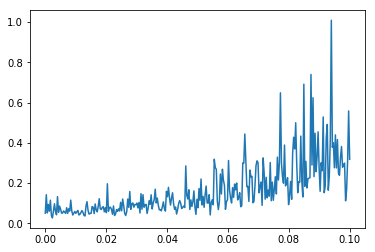

In [60]:
# rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = model.cuda()
lrs, losses = lrfinder(1e-6, 1e-1, rnn, trainset_loader, epochs=10)

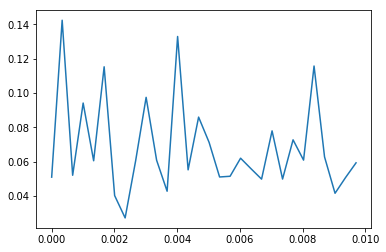

In [61]:
plt.plot(lrs[:30], losses[:30])

Training

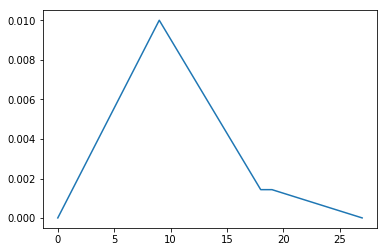

In [39]:
def get_triangular_lr(lr_low, lr_high, mini_batches, epochs_number = 1):
    iterations = mini_batches*epochs_number
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-5, 1e-2, len(trainset_loader))
plt.plot(lrs_triangular)

In [40]:
len(lrs_triangular)

28

In [41]:
def train_model(model, lrs_triangular, epochs_number=10, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lrs_triangular[0], weight_decay=wd)
    ctr = 0
    
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for batch in trainset_loader:
            try: 
                optimizer.param_groups[0]['lr'] = lrs_triangular[ctr]
            except IndexError: pass
            ctr+=1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_edm_transfer.pth')
            best_val_loss = current_val_loss
    return best_val_loss

**IMP: Run load model chunks again as we did lrfinder and it would have changed some things**

In [64]:
# rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = model.cuda()
lrs_triangular = get_triangular_lr(1e-5, 1e-2, len(trainset_loader),epochs_number=10)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.06981370635330678
Validation Loss: Epoch: 0 : 0.2585260493947235

Training Loss: Epoch: 1 : 0.060961370108028254
Validation Loss: Epoch: 1 : 0.22128652788909473

Training Loss: Epoch: 2 : 0.06544630657881498
Validation Loss: Epoch: 2 : 0.1972692566667457

Training Loss: Epoch: 3 : 0.07011988467226425
Validation Loss: Epoch: 3 : 0.26869884151488216

Training Loss: Epoch: 4 : 0.07216077086826166
Validation Loss: Epoch: 4 : 0.34146544641169096

Training Loss: Epoch: 5 : 0.07377646354337533
Validation Loss: Epoch: 5 : 0.2557009874107029

Training Loss: Epoch: 6 : 0.05675916572411855
Validation Loss: Epoch: 6 : 0.23143271744100105

Training Loss: Epoch: 7 : 0.05402552373707294
Validation Loss: Epoch: 7 : 0.2291895465733913

Training Loss: Epoch: 8 : 0.05531253106892109
Validation Loss: Epoch: 8 : 0.22906451669622957

Training Loss: Epoch: 9 : 0.05796413446466128
Validation Loss: Epoch: 9 : 0.22773264922708772



We see a lot of fluctuations here. How can we reduce validation fluctuations? Maybe let's try some weight decay and also increase learning rate base value

In [65]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader),epochs_number=10)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-3)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.059706832841038705
Validation Loss: Epoch: 0 : 0.2084921050099803

Training Loss: Epoch: 1 : 0.06642130427062512
Validation Loss: Epoch: 1 : 0.25980754211193013

Training Loss: Epoch: 2 : 0.06222023963928223
Validation Loss: Epoch: 2 : 0.22847052469560686

Training Loss: Epoch: 3 : 0.06635505643983682
Validation Loss: Epoch: 3 : 0.20769095688851819

Training Loss: Epoch: 4 : 0.06736637738843759
Validation Loss: Epoch: 4 : 0.22633304751709818

Training Loss: Epoch: 5 : 0.05842055417597294
Validation Loss: Epoch: 5 : 0.20510935245929257

Training Loss: Epoch: 6 : 0.06362609788775445
Validation Loss: Epoch: 6 : 0.20880045545293252

Training Loss: Epoch: 7 : 0.06547127986947696
Validation Loss: Epoch: 7 : 0.2214585384940686

Training Loss: Epoch: 8 : 0.06284945520261924
Validation Loss: Epoch: 8 : 0.2249645063072253

Training Loss: Epoch: 9 : 0.061557447910308837
Validation Loss: Epoch: 9 : 0.20827686599327147



In [68]:
lrs_triangular = get_triangular_lr(1e-4, 1e-3, len(trainset_loader),epochs_number=10)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-4)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.07476487122476101
Validation Loss: Epoch: 0 : 0.22935116183697563

Training Loss: Epoch: 1 : 0.06101595759391785
Validation Loss: Epoch: 1 : 0.19894842542336752

Training Loss: Epoch: 2 : 0.061544607083002724
Validation Loss: Epoch: 2 : 0.20950642221997423

Training Loss: Epoch: 3 : 0.060450192416707675
Validation Loss: Epoch: 3 : 0.20332788952175326

Training Loss: Epoch: 4 : 0.05835615967710813
Validation Loss: Epoch: 4 : 0.21540774358022713

Training Loss: Epoch: 5 : 0.05948827266693115
Validation Loss: Epoch: 5 : 0.22094743136549577

Training Loss: Epoch: 6 : 0.05646660178899765
Validation Loss: Epoch: 6 : 0.2312817717218324

Training Loss: Epoch: 7 : 0.05775211428602536
Validation Loss: Epoch: 7 : 0.21434767833735843

Training Loss: Epoch: 8 : 0.056359592949350674
Validation Loss: Epoch: 8 : 0.20397461929505614

Training Loss: Epoch: 9 : 0.056974614039063454
Validation Loss: Epoch: 9 : 0.2045374051632883



In [69]:
best_val_loss

0.19894842542336752

The losses are fluctuating a lot and validation is no more converging. ??

### Unfreezing layers now and training again for some epochs

In [70]:
rnn.load_state_dict(torch.load('music_edm_transfer.pth'))

### Validation

In [71]:
current_sequence_input = torch.zeros(1, 1, 88)
current_sequence_input[0, 0, 40] = 1
current_sequence_input[0, 0, 50] = 0
current_sequence_input[0, 0, 56] = 0
current_sequence_input = Variable(current_sequence_input.cuda())

In [72]:
current_sequence_input.data.squeeze(1)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]], device='cuda:0')

In [73]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    
    else:
        current_sequence_input = Variable(starting_sequence)
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None    

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

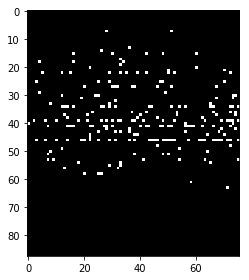

In [84]:
sample = sample_from_piano_rnn(sample_length=75, temperature=0.5).transpose()
io.imshow(sample)

In [105]:
midiwrite('sample.mid', sample.transpose(), dt=0.3)

In [106]:
FileLink('sample.mid')

/home/ubuntu/music-generation/sample.mid

Testloader

In [107]:
testset = NotesGenerationDataset('data/calvin_avicii/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                            shuffle=True, num_workers=4, drop_last=False)

In [108]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()

In [109]:
sample_orig = batch[0].numpy()

In [110]:
sample_orig.shape

(1, 23, 88)

In [111]:
sample_orig = sample_orig.reshape((sample_orig.shape[1], sample_orig.shape[2]))

In [112]:
midiwrite('test0_orig.mid', sample_orig, dt=0.3)

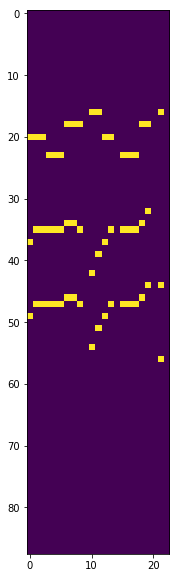

In [113]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(sample_orig.transpose())

In [114]:
FileLink('test0_orig.mid')

/home/ubuntu/music-generation/test0_orig.mid

In [115]:
input_sequences_batch_var.shape

torch.Size([22, 1, 88])

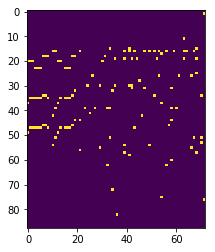

In [116]:
sample = sample_from_piano_rnn(sample_length=50, temperature=0.7, 
                               starting_sequence=input_sequences_batch_var).transpose()
plt.imshow(sample)

In [117]:
sample.shape

(88, 72)

In [118]:
midiwrite('test0.mid', sample.transpose(), dt=0.3)

In [119]:
FileLink('test0.mid')

/home/ubuntu/music-generation/test0.mid